Regularization Methods and Variations on the Cost Function
================================================

In this Jupyter Notebook...

* Apply multi-variable linear regression to model the mechanical properties of zeolite frameworks against local, structural, and porosity-related descriptors

* Apply ridge regression to limit the effect of the weaker covariates

* Demonstrate how the parameter $\lambda$ influences the spectrum of coefficients from a ridge regression

Import the necessary modules

In [1]:
import numpy as np
import sys
import pandas as pd
import scipy as sp
sys.path.append('../')
import matplotlib.pyplot as plt

Load the data [DFT training set from Evans, Jack D., and François-Xavier Coudert. "Predicting the mechanical properties of zeolite frameworks by machine learning." Chemistry of Materials 29, no. 18 (2017): 7833-7839.]

In [2]:
data = pd.read_csv("data/zeolite_mech.csv", low_memory = False)
covariate_name = ['density', 'spg', 'volume', 'SiOSi_average', 'SiO_average', 'max_dim',
                  'largest_free_sphere', 'VolFrac', 'ASA', 'AV']
x = np.array(data['g_gbr'])
t = np.array(data[['density', 'spg', 'volume', 'SiOSi_average', 'SiO_average', 'max_dim',
                  'largest_free_sphere', 'VolFrac', 'ASA', 'AV']])

Center and standardize the data

In [3]:
n_e = len(x)
n_t = len(t[0,:])
t_cen = np.zeros((n_e, n_t))

x_cen = (x - np.sum(x) / n_e)
x_cen /= np.sqrt(np.sum(x_cen ** 2) / (n_e - 1))
for i in range(n_t):
    t_cen[:, i] = (t[:, i] - np.sum(t[:, i]) / n_e)
    t_cen[:, i] /= np.sqrt(np.sum(t_cen[:, i] ** 2) / (n_e - 1))

Perform a multi-variable regression (without regularization method)

In [4]:
mt = np.zeros(n_t+1)
tt = np.zeros((n_t+1, n_t+1))

mt[0] = 0
tt[0,0] = 1
for i in range(n_t):
    mt[i+1] = np.mean(x_cen * t_cen[:,i])
    tt[i+1,0] = np.mean(t_cen[:,i])
    tt[0,i+1] = np.mean(t_cen[:,i])
    for j in range(n_t):
        tt[i+1,j+1] = np.mean(t_cen[:,i] * t_cen[:,j])

In [5]:
tt_inv = np.linalg.inv(tt)
a = np.dot(tt_inv, mt)

Show plots of the linear regression for the four covariates with the largest magnitude of coefficients

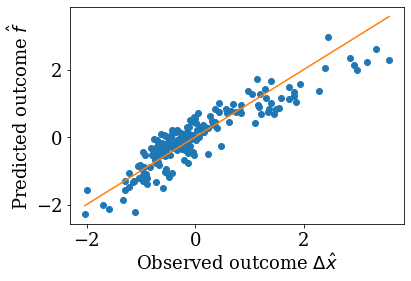

In [6]:
ind = np.argsort(np.abs(a))
f = np.dot(t_cen, a[1:])
x_vec = np.linspace(np.min(x_cen),np.max(x_cen),20)

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(x_cen, f)
plt.plot(x_vec,x_vec,color = 'C1')

plt.xlabel('Observed outcome $\Delta \hat{x}$')
plt.ylabel('Predicted outcome $\hat{f}$')

plt.show()

In [7]:
print(a[ind])
print(ind)
for i in range(1,5):
    print(covariate_name[ind[-i]])

[-1.60144027e-16  2.67720156e-02 -4.20323685e-02  4.27440079e-02
  1.00291592e-01  1.13432734e-01  1.38715328e-01 -4.45639520e-01
  6.79747855e-01  6.86120694e-01  8.02984991e-01]
[ 0  9  7  2  6  5 10  8  3  1  4]
SiO_average
spg
SiOSi_average
ASA


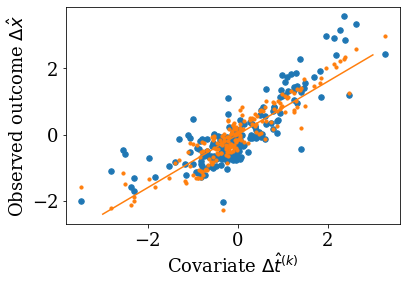

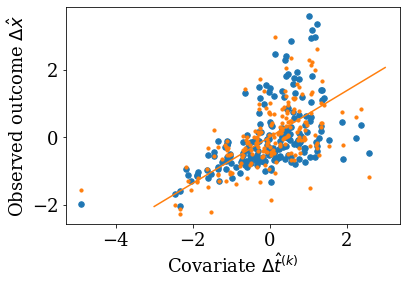

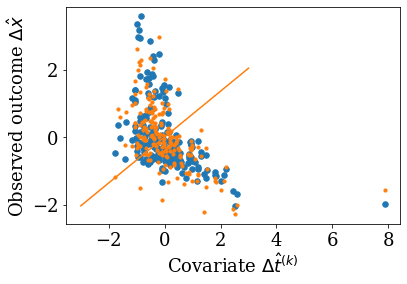

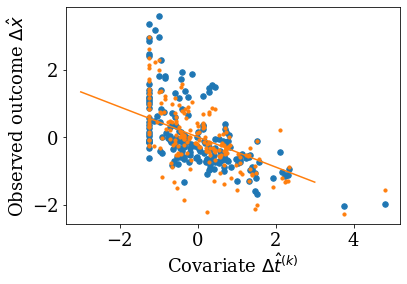

In [8]:
t_vec = np.linspace(-3,3,20)

for i in range(1,5):
    plt.figure(i)
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    plt.rc('font', **font)

    plt.scatter(t_cen[:,ind[-i]-1],x_cen, color = 'C0', s=30)
    plt.scatter(t_cen[:,ind[-i]-1],f, color = 'C1', s=10)
    plt.plot(t_vec,a[ind[-i]] * t_vec, color = 'C1')

    plt.xlabel('Covariate $\Delta \hat{t}^{(k)}$')
    plt.ylabel('Observed outcome $\Delta \hat{x}$')

    plt.show(i)

Perform Ridge regression for various values of lambda

In [9]:
lam_vec = np.logspace(-3,0,5)
a_ridge = np.zeros((len(lam_vec), n_t+1))

ip_mat = np.eye(n_t + 1)
ip_mat[0,0] = 0
for i in range(len(lam_vec)):
    tt_inv = np.linalg.inv(tt + lam_vec[i] * ip_mat)
    a_ridge[i,:] = np.dot(tt_inv, mt)

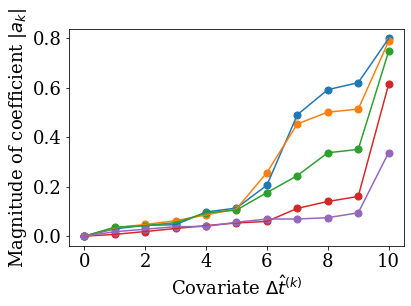

In [10]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

for i in range(len(lam_vec)):
    ind = np.argsort(np.abs(a_ridge[i,:]))

    plt.scatter(np.arange(n_t+1),np.abs(a_ridge[i,ind]),s = 50)
    plt.plot(np.arange(n_t+1),np.abs(a_ridge[i,ind]))

    plt.xlabel('Covariate $\Delta \hat{t}^{(k)}$')
    plt.ylabel('Magnitude of coefficient $|a_{k}|$')

#plt.savefig('figures/regularization/coef_ridge.pdf', bbox_inches='tight')
plt.show()


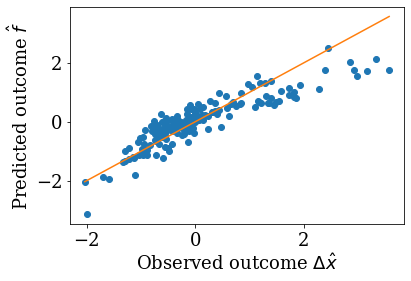

In [11]:
ind = np.argsort(np.abs(a_ridge[3,:]))
f = np.dot(t_cen, a_ridge[3,1:])
x_vec = np.linspace(np.min(x_cen),np.max(x_cen),20)

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(x_cen, f)
plt.plot(x_vec,x_vec,color = 'C1')

plt.xlabel('Observed outcome $\Delta \hat{x}$')
plt.ylabel('Predicted outcome $\hat{f}$')

#plt.savefig('figures/regularization/predict_ridge.pdf', bbox_inches='tight')
plt.show()

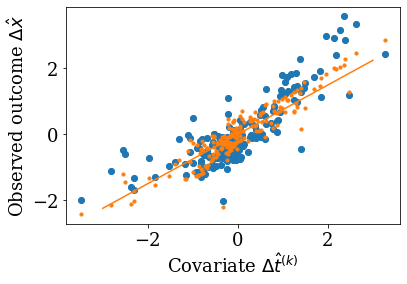

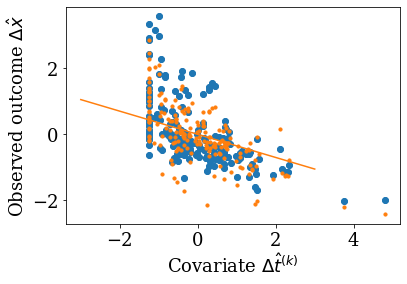

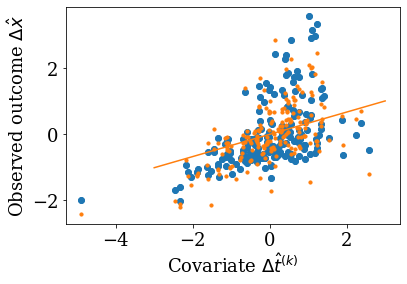

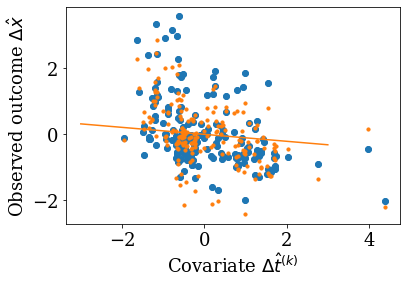

In [12]:
t_vec = np.linspace(-3,3,20)

i_lam = 2
f = np.dot(t_cen, a_ridge[i_lam,1:])

for i in range(1,5):
    plt.figure(i)
    font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
    plt.rc('font', **font)

    plt.scatter(t_cen[:,ind[-i]-1],x_cen)
    plt.scatter(t_cen[:,ind[-i]-1],x_cen, color = 'C0', s=30)
    plt.scatter(t_cen[:,ind[-i]-1],f, color = 'C1', s=10)
    plt.plot(t_vec, a_ridge[i_lam,ind[-i]] * t_vec, color = 'C1')

    plt.xlabel('Covariate $\Delta \hat{t}^{(k)}$')
    plt.ylabel('Observed outcome $\Delta \hat{x}$')

    plt.show(i)

In [13]:
lam_vec

array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])